In [1]:
import scipy.stats as stats
from scipy.special import comb
from statsmodels.stats.contingency_tables import mcnemar
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
path = '/zhome/27/c/138037/share/logs/'
print(path)
from pprint import pprint

/zhome/27/c/138037/share/logs/


In [2]:
df = pd.read_csv(path + 'hparams_table.csv', header=0, names=['loss_function', 'weighted_sampler', 'test_accuracy'])
intensity = pd.read_csv(path + 'intensity.csv', header=0, names=['type', 'seed', 'test_accuracy'])
lossfunction = pd.read_csv(path + 'lossfunction.csv', header=0, names=['function', 'seed', 'test_accuracy'])
weighted = pd.read_csv(path + 'weighted.csv', header=0, names=['weighted', 'seed', 'test_accuracy'])
model = pd.read_csv(path + 'model_choice.csv', header=0, names=['model', 'loss_function', 'seed', 'test_accuracy'])
color_5ch = pd.read_csv(path + 'color.csv', header=0, names=['seed', 'color', 'test_accuracy'])
color_6ch = pd.read_csv(path + 'color_6ch_and_rgbo.csv', header=0, names=['seed', 'color', 'test_accuracy'])
lossfunction_wAlpha = pd.read_csv(path + 'loss_function.csv', header=0, names=['function', 'seed', 'test_accuracy'])
true = np.load('/zhome/27/c/138037/foss/src/true_labels.npy')
pred_cnn = np.load('/zhome/27/c/138037/foss/src/predictions.npy')
pred_res = np.load('/zhome/27/c/138037/foss/src/predictions_resnet.npy')
pred_tree = np.load('/zhome/27/c/138037/share/src/predictions_tree.npy')

In [3]:
def contingency(x,y):  
    YY = len(true[(true == x) & (true == y)])
    YN = len(true[(true == x) & (true != y)])
    NN = len(true[(true != x) & (true != y)])
    NY = len(true[(true != x) & (true == y)])
    return np.array([[YY, YN],[NY, NN]])

cnn_v_res = contingency(pred_cnn,pred_res)
cnn_v_base = contingency(pred_cnn,pred_tree)
res_v_base = contingency(pred_res,pred_tree)

df1 = pd.DataFrame(cnn_v_res, 
                  index = ['CNN: True', 'CNN: False'],
                  columns = ['ResNet: True', 'ResNet: False'])
df2 = pd.DataFrame(cnn_v_base, 
                  index = ['CNN: True', 'CNN: False'],
                  columns = ['Baseline: True', 'Baseline: False'])
df3 = pd.DataFrame(res_v_base, 
                  index = ['ResNet: True', 'ResNet: False'],
                  columns = ['Baseline: True', 'Baseline: False'])

In [4]:
df1.to_numpy()


array([[6225,  259],
       [  67,   49]])

(562.4950005126864, 2.4092098691164214e-124, 1, array([[6.24920061e+03, 2.34799394e+02],
       [1.11799394e+02, 4.20060606e+00]]))


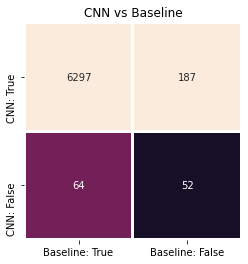

In [11]:
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = sn.heatmap(df2, annot=True, linewidths=2, vmin=49, vmax=100,robust=True, fmt='.0f', cbar=False)
plt.yticks([0.5,1.5],['CNN: True', 'CNN: False'])
plt.title('''CNN vs Baseline''')
#plt.show()
plt.savefig('../img/contingency-cnn-v-base.png')
print(stats.chi2_contingency(df2 ,correction=True))

In [5]:

'''
statistic = (Yes/No - No/Yes)^2 / (Yes/No + No/Yes)
'''

print(f"CNN vs ResNet: {mcnemar(df1.to_numpy(), exact=False, correction=True)}" + '\n' +
      f"CNN vs Base: {mcnemar(df2.to_numpy(), exact=False, correction=True)}" + '\n' +
      f"ResNet vs Base: {mcnemar(df3.to_numpy(), exact=False, correction=True)}")


CNN vs ResNet: pvalue      3.748656609376213e-26
statistic   111.90490797546012
CNN vs Base: pvalue      1.354587868112004e-14
statistic   59.298804780876495
ResNet vs Base: pvalue      0.0012345400127623935
statistic   10.437923250564333


In [15]:
image = intensity[intensity['type'] == 'image'].values[:,2]
channel = intensity[intensity['type'] == 'channel'].values[:,2]
imagechannel = intensity[intensity['type'] == 'imagechannel'].values[:,2]
none = intensity[intensity['type'] == 'none'].values[:,2]
convnet_cross = model[(model['model'] == 'ConvNet') & (model['loss_function'] == 'crossentropy')].values[:,3]
convnet_focal = model[(model['model'] == 'ConvNet') & (model['loss_function'] == 'focal')].values[:,3]
convnetscale_cross = model[(model['model'] == 'ConvNetScale') & (model['loss_function'] == 'crossentropy')].values[:,3]
convnetscale_focal = model[(model['model'] == 'ConvNetScale') & (model['loss_function'] == 'focal')].values[:,3]
crossentropy = lossfunction[lossfunction['function'] == 'crossentropy'].values[:,2]
focal = lossfunction[lossfunction['function'] == 'focal'].values[:,2]
weights_on = weighted[weighted['weighted'] == 1.0].values[:,2]
weights_off = weighted[weighted['weighted'] == 0.0].values[:,2]
uv_5ch = color_5ch[color_5ch['color'] == 0.0].values[:,2]
nearir_5ch = color_5ch[color_5ch['color'] == 5.0].values[:,2]
threed_5ch = color_5ch[color_5ch['color'] == 6.0].values[:,2]
rgbo = color_6ch[color_6ch['color'] == 1.0].values[:,2]
# After above three experiments NearIR was added
uv_6ch = color_6ch[color_6ch['color'] == 0.0].values[:,2]
threed_6ch = color_6ch[color_6ch['color'] == 6.0].values[:,2]
focal_alpha = lossfunction_wAlpha[lossfunction_wAlpha['function'] == 'alphafocal'].values[:,2]

Testing the second forward channel selection
UV vs 3D: (-0.3639205513217448, 0.7253475684504338)


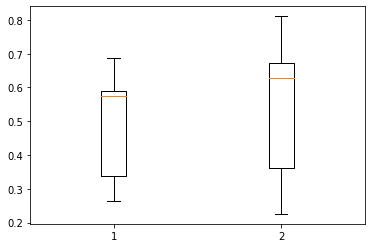

In [20]:
# Printint ttest result for the second forward channel selection (With NearIR selected from previous step - test seen below this block)
print('Testing the second forward channel selection')
print(f"UV vs 3D: {stats.ttest_ind(uv_6ch, threed_6ch)[:]}")
plt.boxplot([uv_6ch, threed_6ch])
plt.show()

In [76]:
temp = threed_6ch
print(f"{np.max(temp)}" + '\n' +
f"{np.min(temp)}" + '\n' +
f"{np.mean(temp)}" + '\n' +
f"{np.std(temp)}")

0.8109090924263
0.22545453906059265
0.5397272765636444
0.21438078920511192


Testing the first forward channel selection
RGBO vs UV: (-1.2337917643445262, 0.25229619122506114)
RGBO vs Near IR: (-20.227678952930678, 3.7270951232026615e-08)
RGBO vs 3D: (0.4209017020725576, 0.6849064735500245)
UV vs Near IR: (-23.2141047135971, 1.2593904213561485e-08)
UV vs 3D: (3.0934998818666726, 0.03645024851450993)
Near IR vs 3D: (21.325479459296016, 2.459007075472502e-08)


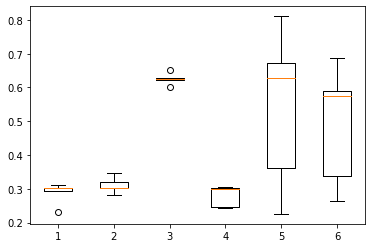

In [61]:
# Printint ttest result for the first forward channel selection
print('Testing the first forward channel selection')
print(f"5th channel RGBO vs UV: {stats.ttest_ind(rgbo, uv_5ch)[:]}" + '\n' +
      f"5th channel RGBO vs Near IR: {stats.ttest_ind(rgbo, nearir_5ch)[:]}" + '\n' +
      f"5th channel RGBO vs 3D: {stats.ttest_ind(rgbo, threed_5ch)[:]}" + '\n' +
      f"6th channel UV vs Near IR: {stats.ttest_ind(uv_5ch, nearir_5ch)[:]}" + '\n' +
     f"6th channel UV vs 3D: {stats.ttest_rel(uv_5ch, threed_5ch)[:]}" + '\n' +
     f"6th channel Near IR vs 3D: {stats.ttest_ind(nearir_5ch, threed_5ch)[:]}")
plt.boxplot([rgbo, uv_5ch, nearir_5ch, threed_5ch, threed_6ch, uv_6ch,])
plt.show()

Image vs Channel: (-5.1292608636758406, 0.0008969023654277734)
Image vs Image & Channel: (9.061869224132844, 1.7620473447560064e-05)
Image vs None: (-3.8301374913592867, 0.005016935149115001)
Channel vs Image & Channel: (26.388615649042105, 4.571137753293593e-09)
Channel vs None: (0.7898806372586312, 0.45237205897613875)
Image & Channel vs None: (-16.256260415257632, 2.0625932012970363e-07)
ConvNet_cross vs ConvNetScale_cross: (-0.21710044616308855, 0.8335644838986451)
ConvNet_focal vs ConvNetScale_focal: (1.6143824717634472, 0.1451082246039102)
Crossentropy vs Focal: (0.3458894090713, 0.7383459827114425)
Crossentropy vs Focal_alpha: (-1.1279128544187784, 0.2920452669057029)
Focal vs Focal_alpha: (-1.314960161334959, 0.22496344987358446)
Weighted vs Non weighted: (-8.7400629289221, 2.2974824548068628e-05)


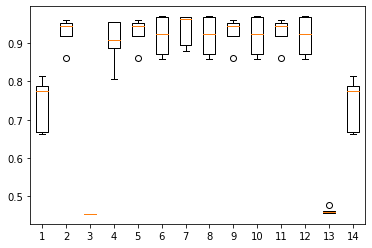

In [11]:
print(f"Image vs Channel: {stats.ttest_ind(image, channel)[:]}" + '\n' +
     f"Image vs Image & Channel: {stats.ttest_ind(image, imagechannel)[:]}" + '\n' +
     f"Image vs None: {stats.ttest_ind(image, none)[:]}" + '\n' +
     f"Channel vs Image & Channel: {stats.ttest_ind(channel, imagechannel)[:]}" + '\n' +
     f"Channel vs None: {stats.ttest_ind(channel, none)[:]}" + '\n' +
     f"Image & Channel vs None: {stats.ttest_ind(imagechannel, none)[:]}" + '\n' +
     f"ConvNet_cross vs ConvNetScale_cross: {stats.ttest_ind(convnet_cross, convnetscale_cross)[:]}" + '\n' +
     f"ConvNet_focal vs ConvNetScale_focal: {stats.ttest_ind(convnet_focal, convnetscale_focal)[:]}" + '\n' +
     f"Crossentropy vs Focal: {stats.ttest_ind(crossentropy, focal)[:]}" + '\n' +
     f"Crossentropy vs Focal_alpha: {stats.ttest_ind(crossentropy, focal_alpha)[:]}" + '\n' +
     f"Focal vs Focal_alpha: {stats.ttest_ind(focal, focal_alpha)[:]}" + '\n' +
     f"Weighted vs Non weighted: {stats.ttest_ind(weights_on, weights_off)[:]}")

plt.boxplot([image, channel, imagechannel, none, convnet_cross, convnet_focal, convnetscale_cross, convnet_focal, crossentropy, focal, alpha_cross, alpha_focal,weights_on, weights_off])
plt.show()

In [32]:
print(f"Comparing test-accuracies of crossentropy and focal: \n{crossentropy.mean(), focal.mean()}")

Comparing test-accuracies of crossentropy and focal: 
(0.9277272701263428, 0.9175757646560669)


In [25]:
weighted_focal = df[(df['loss_function'] == 'focal') & (df['weighted_sampler'] == 1.0)].values[:,2]
not_weighted_focal = df[(df['loss_function'] == 'focal') & (df['weighted_sampler'] == 0.0)].values[:,2]
weighted_cross = df[(df['loss_function'] == 'crossentropy') & (df['weighted_sampler'] == 1.0)].values[:,2]
not_weighted_cross = df[(df['loss_function'] == 'crossentropy') & (df['weighted_sampler'] == 0.0)].values[:,2]

Testing weighted vs non_weighted and focal vs cross loss functions
Weighted+Focal vs not weighted+Focal: (-2.3502820508615714, 0.030363032978179195)
Weighted+Focal vs weighted+Cross: (-1.0815841310051906, 0.29371540150937575)
Weighted+Focal vs not weighted+Cross: (-0.84988791429064, 0.40655028998426257)
Not weighted+Focal vs weighted+Cross: (1.7216946038098004, 0.1022651302876761)
Not weighted+Focal vs not weighted+Cross: (0.9857113297675522, 0.3373401893543142)
Weighted+Cross vs not weighted+Cross: (-0.212458021274299, 0.8341371270178315)


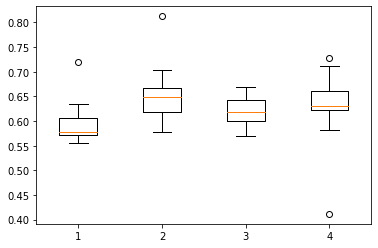

In [26]:
print('Testing weighted vs non_weighted and focal vs cross loss functions')
print(f"Weighted+Focal vs not weighted+Focal: {stats.ttest_ind(weighted_focal, not_weighted_focal)[:]}" + '\n' +
      f"Weighted+Focal vs weighted+Cross: {stats.ttest_ind(weighted_focal, weighted_cross)[:]}" + '\n' +
      f"Weighted+Focal vs not weighted+Cross: {stats.ttest_ind(weighted_focal, not_weighted_cross)[:]}" + '\n' +
      f"Not weighted+Focal vs weighted+Cross: {stats.ttest_ind(not_weighted_focal, weighted_cross)[:]}" + '\n' +
     f"Not weighted+Focal vs not weighted+Cross: {stats.ttest_ind(not_weighted_focal, not_weighted_cross)[:]}" + '\n' +
     f"Weighted+Cross vs not weighted+Cross: {stats.ttest_ind(weighted_cross, not_weighted_cross)[:]}")
plt.boxplot([weighted_focal, not_weighted_focal, weighted_cross, not_weighted_cross])
plt.show()

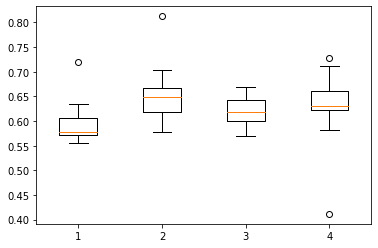

In [91]:
plt.boxplot([a,b,c,d]) # ticks=['not_weighted', '','',''])
plt.show()